## REad the data

In [184]:
import pandas as pd
from sodapy import Socrata
import numpy as np

In [185]:

import pandas as pd
from sodapy import Socrata

client = Socrata("data.texas.gov", None)

results = client.get("ubdr-4uff", limit=300000)

# Convert to pandas DataFrame
df1 = pd.DataFrame.from_records(results)

In [186]:
df = df1

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259508 entries, 0 to 259507
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   complaint_number          259508 non-null  object
 1   respondent_name           259508 non-null  object
 2   complainant_role          259508 non-null  object
 3   reason                    259502 non-null  object
 4   complaint_confirmed_code  259503 non-null  object
 5   disposition               258470 non-null  object
 6   received_date             259508 non-null  object
 7   closed_date               259508 non-null  object
 8   complaint_type            259507 non-null  object
 9   coverage_type             259508 non-null  object
 10  coverage_level            259508 non-null  object
 11  respondent_id             259508 non-null  object
 12  respondent_role           259506 non-null  object
 13  respondent_type           259508 non-null  object
 14  comp

In [188]:
# Drop missing rows in disposition coluMN
df = df.dropna(subset=['disposition'])

In [189]:

# get counts of disposition values in descending order
disposition_counts = df['disposition'].value_counts().sort_values(ascending=False)
print(disposition_counts)


disposition
Contract Language/Legal Issue                                                             25698
No Jurisdiction                                                                           23533
Information Furnished                                                                     17925
Question of Fact                                                                          12215
Information Furnished; Contract Language/Legal Issue                                       8209
                                                                                          ...  
Agent 1st warning; Information Furnished; Agent Resp Recvd                                    1
Contract Language/Legal Issue; Referred for Disciplinary Actn; Corrective Action Taken        1
Corrective Action Taken; Agent Resp Recvd                                                     1
Additional Monies Received; Corrective Action Taken; Rate Problem Resolved                    1
Reimburse; Claim Settled    

### Disposition column

In [190]:


# Define keywords for categorizing dispositions as 'verdict won' or 'verdict not won'
verdict_won_keywords = ["Claim Settled", "Additional Monies Received"]
verdict_not_won_keywords = ["No Jurisdiction", "Company Position Upheld", "Insufficient Information", "Contract Language/Legal Issue", "Question of Fact"]

# Function to categorize each disposition based on the presence of keywords
def categorize_verdict(disposition):
    if any(keyword in disposition for keyword in verdict_won_keywords):
        return "Yes"
    elif any(keyword in disposition for keyword in verdict_not_won_keywords):
        return "No"
    else:
        return "Uncategorized"  # For entries that don't match any keywords

# Apply categorization to the disposition data
df['verdict_passed'] = df['disposition'].apply(categorize_verdict)

# Drop rows where the disposition was categorized as "Uncategorized"
df = df[df['verdict_passed'] != "Uncategorized"]

# replace disposition column with verdict_passed column and drop verdict_passed
df['disposition'] = df['verdict_passed']
df = df.drop(columns=['verdict_passed'])


C:\Users\nbngc\AppData\Local\Temp\ipykernel_456\2812971750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verdict_passed'] = df['disposition'].apply(categorize_verdict)


### Encode disposition

In [191]:
df['disposition'].replace(to_replace=['Yes','No'], value=[0,1])
df.head()

C:\Users\nbngc\AppData\Local\Temp\ipykernel_456\2725739056.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['disposition'].replace(to_replace=['Yes','No'], value=[0,1])


,complaint_number,respondent_name,complainant_role,reason,complaint_confirmed_code,disposition,received_date,closed_date,complaint_type,coverage_type,coverage_level,respondent_id,respondent_role,respondent_type,complainant_type,involved_party_type,keyword
4,5,"CHARTER OAK FIRE INSURANCE COMPANY, THE",Insured,Unsatisfactory Settle/Offer,No,No,2012-06-13T00:00:00.000,2012-07-17T00:00:00.000,Property and Casualty,Automobile,Individual Private Pass,2918,Ins Co - Licensed/Active,Organization,INDV,NaN,2012 NORTH TEXAS TORNADOES; ADJUSTER'S HANDLIN...
5,6,REASSURE AMERICA LIFE INSURANCE COMPANY,Insured,Cash Value; Misrepresentation,No,No,2012-06-18T00:00:00.000,2012-07-30T00:00:00.000,"Life, Accident and Health",Life & Annuity,Individual Life,1228,Ins Co - Licensed/Active,Organization,INDV,NaN,NaN
6,7,USAA GENERAL INDEMNITY COMPANY,Third Party,Unsatisfactory Settle/Offer,No,Yes,2012-02-27T00:00:00.000,2012-07-02T00:00:00.000,Property and Casualty,Automobile,Individual Private Pass,1276,Ins Co - Licensed/Active,Organization,INDV,Insured,CLAIM EVALUATION
7,8,"BLUE CROSS AND BLUE SHIELD OF TEXAS, A DIVISIO...",Insured,Denial Of Claim,No,No,2012-06-19T00:00:00.000,2012-08-06T00:00:00.000,"Life, Accident and Health",Accident and Health,Group A&H,10047,Ins Co - Licensed/Active,Organization,INDV,NaN,NaN
8,9,PROPERTY AND CASUALTY INSURANCE COMPANY OF HAR...,Insured,Unsatisfactory Settle/Offer,No,No,2011-10-03T00:00:00.000,2012-07-20T00:00:00.000,Property and Casualty,Homeowners,Homeowners,8123,Ins Co - Licensed/Active,Organization,INDV,NaN,CLAIM EVALUATION; SUPPLEMENTARY PAYMENT


In [192]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Initialize the LabelEncoder
le = LabelEncoder()
df2 = df.copy(deep=True)
# Apply label encoding to each categorical column
for col in categorical_cols:
    df2[col] = le.fit_transform(df2[col])

# Calculate the correlation matrix
corr_matrix = df2.corr()

# Display the correlation matrix
print(corr_matrix)

                          complaint_number  respondent_name  complainant_role  \
complaint_number                  1.000000         0.021514         -0.081489   
respondent_name                   0.021514         1.000000         -0.036528   
complainant_role                 -0.081489        -0.036528          1.000000   
reason                            0.010252        -0.030322          0.193677   
complaint_confirmed_code          0.024779         0.003138          0.009690   
disposition                       0.018286         0.026317          0.023317   
received_date                     0.194552         0.050044         -0.050331   
closed_date                       0.163023         0.047847         -0.041133   
complaint_type                    0.123205         0.054027         -0.056505   
coverage_type                     0.093945         0.064669         -0.275283   
coverage_level                    0.068319         0.005132         -0.066993   
respondent_id               

       complaint_number                                    respondent_name  \
count            206844                                             206844   
unique           201381                                              10482   
top               17138  Blue Cross and Blue Shield of Texas, A Divisio...   
freq                 13                                              16079   

       complainant_role           reason complaint_confirmed_code disposition  \
count            206844           206843                   206839      206844   
unique               31             6562                        2           2   
top             Insured  Denial Of Claim                       No          No   
freq              97834            24225                   178270      151097   

                  received_date              closed_date  \
count                    206844                   206844   
unique                     3784                     3667   
top     2021-02-22T00:0

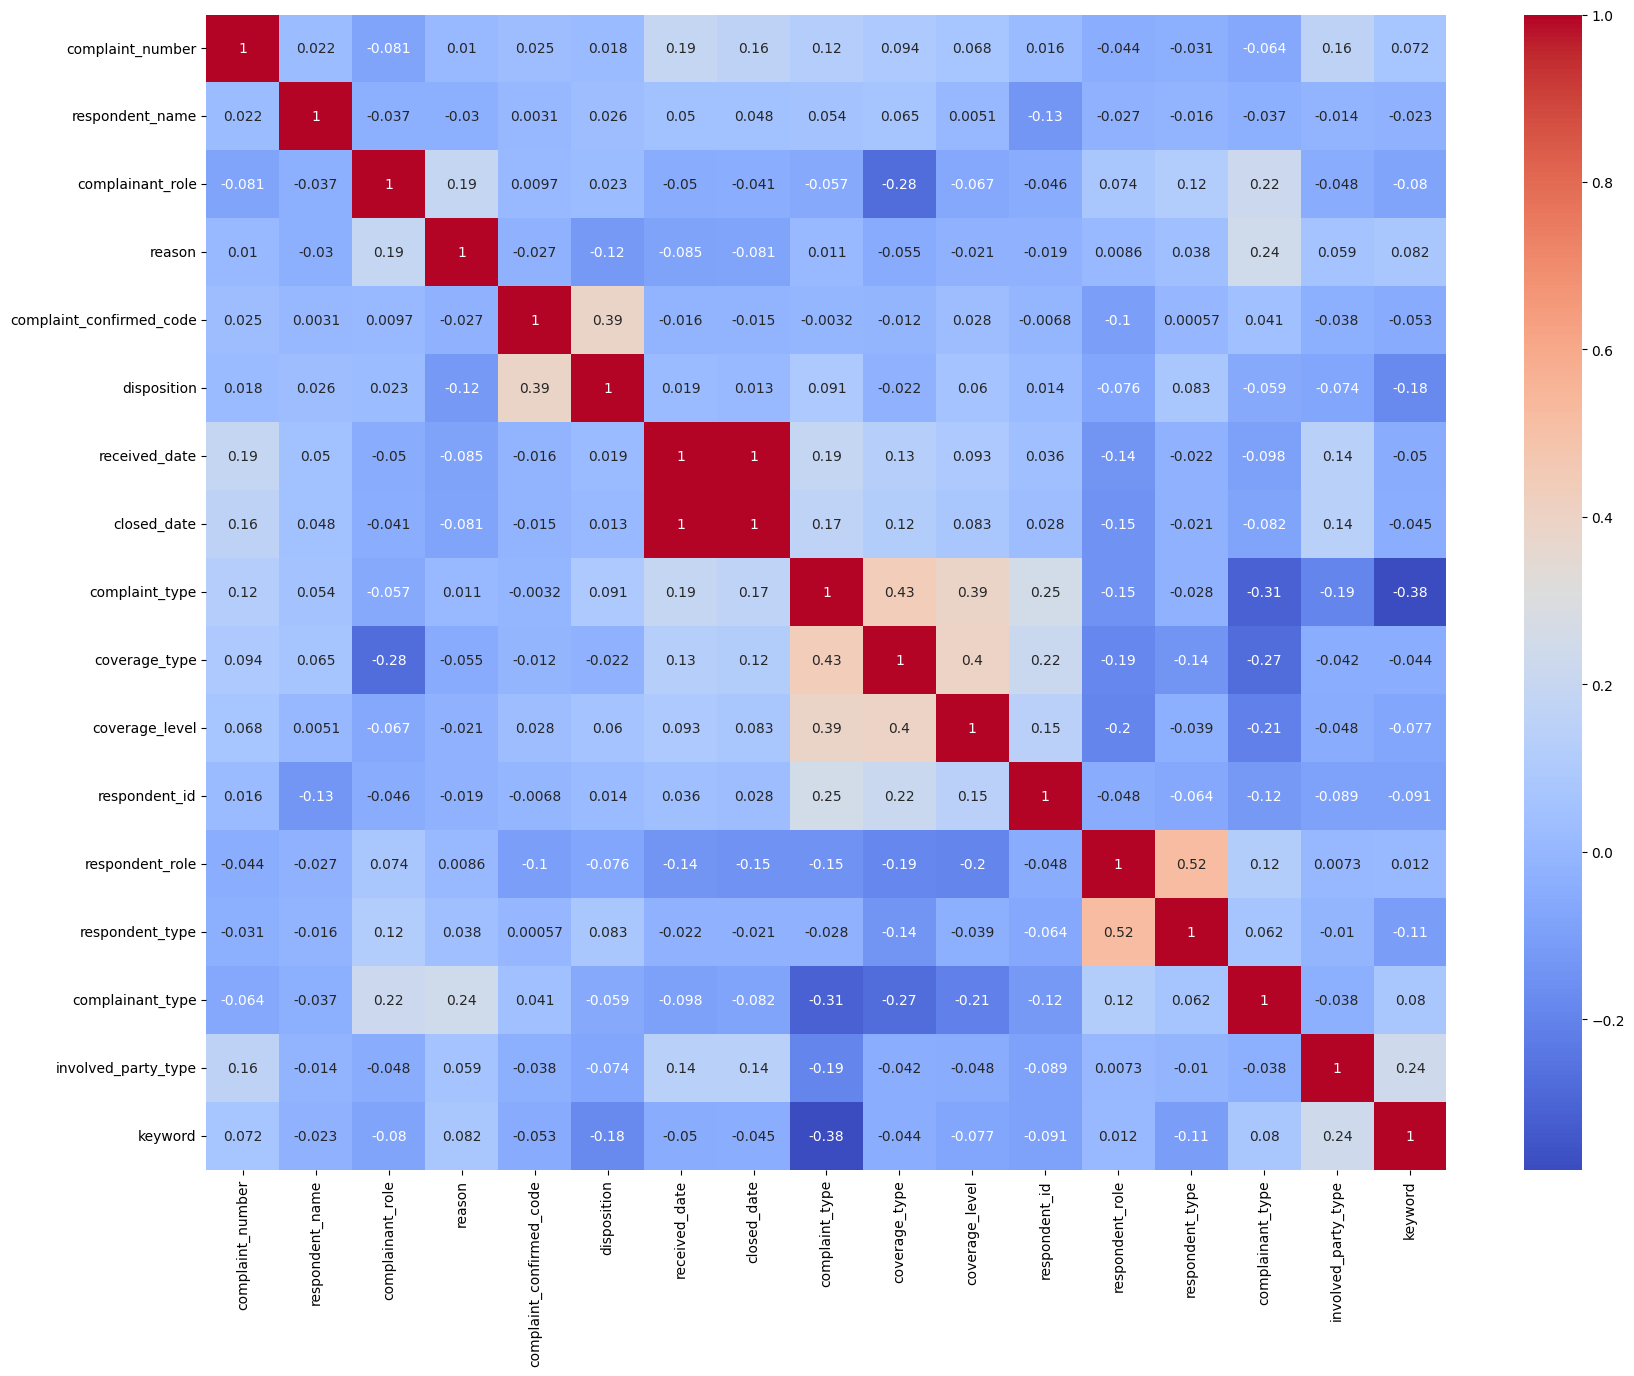

In [193]:
import seaborn as sns

import matplotlib.pyplot as plt

# Summary Statistics
print(df.describe(include='all'))

# Check for missing values
print(df.isnull().sum())


# # Distribution of categorical variables
# # for col in df.select_dtypes(include=['object', 'bool']).columns:
# #     sns.countplot(y=col, data=df)
# #     plt.show()


# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


# Drop unnecessary columns

In [194]:
# drop the columns
# count of individual in column respondant type
df['respondent_type'].value_counts()

# drop columns keyword, respondent_id,complaint_number
df = df.drop(columns=['keyword','respondent_id','complaint_number'])
 

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206844 entries, 4 to 259504
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   respondent_name           206844 non-null  object
 1   complainant_role          206844 non-null  object
 2   reason                    206843 non-null  object
 3   complaint_confirmed_code  206839 non-null  object
 4   disposition               206844 non-null  object
 5   received_date             206844 non-null  object
 6   closed_date               206844 non-null  object
 7   complaint_type            206843 non-null  object
 8   coverage_type             206844 non-null  object
 9   coverage_level            206844 non-null  object
 10  respondent_role           206844 non-null  object
 11  respondent_type           206844 non-null  object
 12  complainant_type          206844 non-null  object
 13  involved_party_type       186400 non-null  object
dtypes: object

### Handle date time objects

In [196]:
df['received_date'] = pd.to_datetime(df['received_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])
df.head()

,respondent_name,complainant_role,reason,complaint_confirmed_code,disposition,received_date,closed_date,complaint_type,coverage_type,coverage_level,respondent_role,respondent_type,complainant_type,involved_party_type
4,"CHARTER OAK FIRE INSURANCE COMPANY, THE",Insured,Unsatisfactory Settle/Offer,No,No,2012-06-13,2012-07-17,Property and Casualty,Automobile,Individual Private Pass,Ins Co - Licensed/Active,Organization,INDV,NaN
5,REASSURE AMERICA LIFE INSURANCE COMPANY,Insured,Cash Value; Misrepresentation,No,No,2012-06-18,2012-07-30,"Life, Accident and Health",Life & Annuity,Individual Life,Ins Co - Licensed/Active,Organization,INDV,NaN
6,USAA GENERAL INDEMNITY COMPANY,Third Party,Unsatisfactory Settle/Offer,No,Yes,2012-02-27,2012-07-02,Property and Casualty,Automobile,Individual Private Pass,Ins Co - Licensed/Active,Organization,INDV,Insured
7,"BLUE CROSS AND BLUE SHIELD OF TEXAS, A DIVISIO...",Insured,Denial Of Claim,No,No,2012-06-19,2012-08-06,"Life, Accident and Health",Accident and Health,Group A&H,Ins Co - Licensed/Active,Organization,INDV,NaN
8,PROPERTY AND CASUALTY INSURANCE COMPANY OF HAR...,Insured,Unsatisfactory Settle/Offer,No,No,2011-10-03,2012-07-20,Property and Casualty,Homeowners,Homeowners,Ins Co - Licensed/Active,Organization,INDV,NaN


In [197]:
# Trim whitespace from all columns with string data
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [198]:
# Convert all columns to propercase if they are strings
df = df.apply(lambda x: x.str.title() if x.dtype == "object" else x)

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206844 entries, 4 to 259504
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   respondent_name           206844 non-null  object        
 1   complainant_role          206844 non-null  object        
 2   reason                    206843 non-null  object        
 3   complaint_confirmed_code  206839 non-null  object        
 4   disposition               206844 non-null  object        
 5   received_date             206844 non-null  datetime64[ns]
 6   closed_date               206844 non-null  datetime64[ns]
 7   complaint_type            206843 non-null  object        
 8   coverage_type             206844 non-null  object        
 9   coverage_level            206844 non-null  object        
 10  respondent_role           206844 non-null  object        
 11  respondent_type           206844 non-null  object        
 12  complai

In [200]:
df

,respondent_name,complainant_role,reason,complaint_confirmed_code,disposition,received_date,closed_date,complaint_type,coverage_type,coverage_level,respondent_role,respondent_type,complainant_type,involved_party_type
4,"Charter Oak Fire Insurance Company, The",Insured,Unsatisfactory Settle/Offer,No,No,2012-06-13,2012-07-17,Property And Casualty,Automobile,Individual Private Pass,Ins Co - Licensed/Active,Organization,Indv,NaN
5,Reassure America Life Insurance Company,Insured,Cash Value; Misrepresentation,No,No,2012-06-18,2012-07-30,"Life, Accident And Health",Life & Annuity,Individual Life,Ins Co - Licensed/Active,Organization,Indv,NaN
6,Usaa General Indemnity Company,Third Party,Unsatisfactory Settle/Offer,No,Yes,2012-02-27,2012-07-02,Property And Casualty,Automobile,Individual Private Pass,Ins Co - Licensed/Active,Organization,Indv,Insured
7,"Blue Cross And Blue Shield Of Texas, A Divisio...",Insured,Denial Of Claim,No,No,2012-06-19,2012-08-06,"Life, Accident And Health",Accident And Health,Group A&H,Ins Co - Licensed/Active,Organization,Indv,NaN
8,Property And Casualty Insurance Company Of Har...,Insured,Unsatisfactory Settle/Offer,No,No,2011-10-03,2012-07-20,Property And Casualty,Homeowners,Homeowners,Ins Co - Licensed/Active,Organization,Indv,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259499,Homesite Insurance Company,Other,Cust Service Claim Handling; Unsatisfactory Se...,No,No,2024-11-04,2024-11-14,Property And Casualty,Homeowners,Homeowners,Ins Co - Licensed/Active,Organization,Indv,Insured; Portal - Attorney; Portal - Company; ...
259500,State Farm Lloyds,Other,Cust Service Claim Handling; Delays (Claims Ha...,No,No,2024-11-04,2024-11-07,Property And Casualty,Homeowners,Homeowners,Ins Co - Licensed/Active,Organization,Indv,Correspondent Person; Portal - Company; Portal...
259502,White Bull Insurance Group Llc,Third Party,Cust Service Claim Handling; Delays (Claims Ha...,No,No,2024-11-07,2024-11-07,Property And Casualty,Automobile,Individual Private Pass,Ins Co - Licensed/Active,Organization,Indv,Portal - Insured; Portal - Other Company
259503,"Health Care Service Corporation, A Mutual Lega...",Third Party Billing Service,Denial Of Claim,No,No,2024-11-13,2024-11-15,"Life, Accident And Health",Accident And Health,Individual A & H,Self-Funded / Erisa,Organization,Org,Insured; Portal - Company; Portal - Insured


In [201]:
label_enco_cols = ["respondent_name", "reason", "involved_party_type"]
one_enco_cols = ["complainant_role", "complaint_confirmed_code","complaint_type","coverage_type","coverage_level","respondent_role","respondent_type", "complainant_type"]

# Remove the text ", The" from respondent_name column if ends in ", The"
df['respondent_name'] = df['respondent_name'].str.rstrip(', The')

# for label_enco_cols do label encoding for one_enco_cols do one hot encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# Label Encoding
for col in label_enco_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# One Hot Encoding
df = pd.get_dummies(df, columns=one_enco_cols, drop_first=True)


In [202]:
# implement MCA on the data
# from prince import MCA
# mca = MCA(n_components=2)
# mca.fit(df)
# mca.plot_coordinates(df, figsize=(15, 15))


In [203]:
df.head()

,respondent_name,reason,disposition,received_date,closed_date,involved_party_type,complainant_role_Attorney,complainant_role_Beneficiary,complainant_role_Consumer (Non-Insured),complainant_role_Contracted Provider,...,respondent_role_Texas Fair Insurance Plan,respondent_role_Third Party Administrators,respondent_role_Twia,respondent_role_U.S. Domiciled Insurer,respondent_role_Unauthorized Activity,respondent_role_Utilization Review Agent,respondent_role_Viatical Settlement Com/Broker,respondent_role_Wc Healthcare Provider Ntwk,respondent_type_Organization,complainant_type_Org
4,1754,6514,No,2012-06-13,2012-07-17,6118,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
5,7006,2469,No,2012-06-18,2012-07-30,6118,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6,8953,6514,Yes,2012-02-27,2012-07-02,5454,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7,1197,5121,No,2012-06-19,2012-08-06,6118,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8,6820,6514,No,2011-10-03,2012-07-20,6118,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [204]:
# write disposition counts to a csv file
df.to_csv('df.csv', index=False)

In [205]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 206844 entries, 4 to 259504
Columns: 173 entries, respondent_name to complainant_type_Org
dtypes: bool(167), datetime64[ns](2), int64(3), object(1)
memory usage: 44.0+ MB
None


### Set Logistic Regression as baseline model

In [206]:
df = df.drop(columns=['received_date', 'closed_date'])

In [207]:
# Scale the data using StandardScaler for all numerical columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Select numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Apply StandardScaler to each numerical column
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()


,respondent_name,reason,disposition,involved_party_type,complainant_role_Attorney,complainant_role_Beneficiary,complainant_role_Consumer (Non-Insured),complainant_role_Contracted Provider,complainant_role_Dwc Appeals Panel,complainant_role_Dwc El Paso,...,respondent_role_Texas Fair Insurance Plan,respondent_role_Third Party Administrators,respondent_role_Twia,respondent_role_U.S. Domiciled Insurer,respondent_role_Unauthorized Activity,respondent_role_Utilization Review Agent,respondent_role_Viatical Settlement Com/Broker,respondent_role_Wc Healthcare Provider Ntwk,respondent_type_Organization,complainant_type_Org
4,-0.860223,1.312436,No,1.085890,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
5,0.797986,-1.282331,No,1.085890,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6,1.412711,1.312436,Yes,0.679806,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7,-1.036084,0.418861,No,1.085890,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8,0.739261,1.312436,No,1.085890,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [208]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming df is already preprocessed and ready for modeling

# Define features and target variable
X = df.drop(columns=['disposition'])
y = df['disposition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=500)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("--------------------")
print(f'Accuracy: {accuracy}')
print("--------------------")
print('Confusion Matrix:')
print(conf_matrix)
print("--------------------")
print('Classification Report:')
print(class_report)
print("--------------------")

--------------------
Accuracy: 0.785718889999033
--------------------
Confusion Matrix:
[[43174  2001]
 [11296  5583]]
--------------------
Classification Report:
              precision    recall  f1-score   support

          No       0.79      0.96      0.87     45175
         Yes       0.74      0.33      0.46     16879

    accuracy                           0.79     62054
   macro avg       0.76      0.64      0.66     62054
weighted avg       0.78      0.79      0.76     62054

--------------------


### Train Test Split

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Split the data into features and target
X = df.drop(columns=['disposition'])
y = df['disposition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Random Forest Classifier

In [210]:
from sklearn.model_selection import StratifiedKFold

# Define the cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Fit the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [211]:
# Get the cross-validation scores
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean cross-validation score
print("Mean cross-validation score:", scores.mean())

# Get the test accuracy
test_accuracy = model.score(X_test, y_test)
print("Test accuracy:", test_accuracy)

# Get the validation accuracy
val_accuracy = model.score(X_val, y_val)
print("Validation accuracy:", val_accuracy)

# Get the feature importances
importances = model.feature_importances_

# Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]

# Get the indices of features whose importance is greater than 0.01
important_indices = [i for i in indices if importances[i] > 0.001]

# filter out the non important features
important_features = X.columns[important_indices]

important_features


Cross-validation scores: [0.78871294 0.78274382 0.78165853 0.79102121 0.78317711]
Mean cross-validation score: 0.7854627220987878
Test accuracy: 0.7841718503239115
Validation accuracy: 0.7870709303128669


Index(['involved_party_type', 'reason', 'respondent_name',
       'complaint_confirmed_code_Yes',
       'respondent_role_Ins Co - Licensed/Active',
       'respondent_role_Self-Funded / Erisa', 'complainant_type_Org',
       'complaint_type_Life, Accident And Health', 'complainant_role_Insured',
       'coverage_level_Individual Private Pass', 'coverage_type_Automobile',
       'complainant_role_Third Party', 'respondent_type_Organization',
       'complainant_role_Third Party Billing Service',
       'coverage_level_Group A&H', 'complainant_role_Provider',
       'complainant_role_Other', 'complaint_type_Property And Casualty',
       'complaint_type_Employee Retirement System',
       'complaint_type_Health Maintenance Org',
       'coverage_level_Individual A & H',
       'respondent_role_Health Maintenance Org', 'complainant_role_Attorney',
       'respondent_role_Insurance Agency', 'complainant_role_Relative',
       'coverage_type_Life & Annuity',
       'complainant_role_Consum

Feature ranking:
involved_party_type: 0.2571437281555953
reason: 0.23931577557770484
respondent_name: 0.22622504227542145
complaint_confirmed_code_Yes: 0.14973314533327356
respondent_role_Ins Co - Licensed/Active: 0.012891678709421728
respondent_role_Self-Funded / Erisa: 0.010238985058965795
complainant_type_Org: 0.006986251054351935
complaint_type_Life, Accident And Health: 0.0069411630292787055
complainant_role_Insured: 0.005840349252296536
coverage_level_Individual Private Pass: 0.005779107974978106
coverage_type_Automobile: 0.005418821750410655
complainant_role_Third Party: 0.005269889976420408
respondent_type_Organization: 0.0046811314782523265
complainant_role_Third Party Billing Service: 0.004303427996141487
coverage_level_Group A&H: 0.003679184474715006
complainant_role_Provider: 0.003298942221162808
complainant_role_Other: 0.0032760359089593
complaint_type_Property And Casualty: 0.0029821908805949065
complaint_type_Employee Retirement System: 0.002828665854627287
complaint_typ

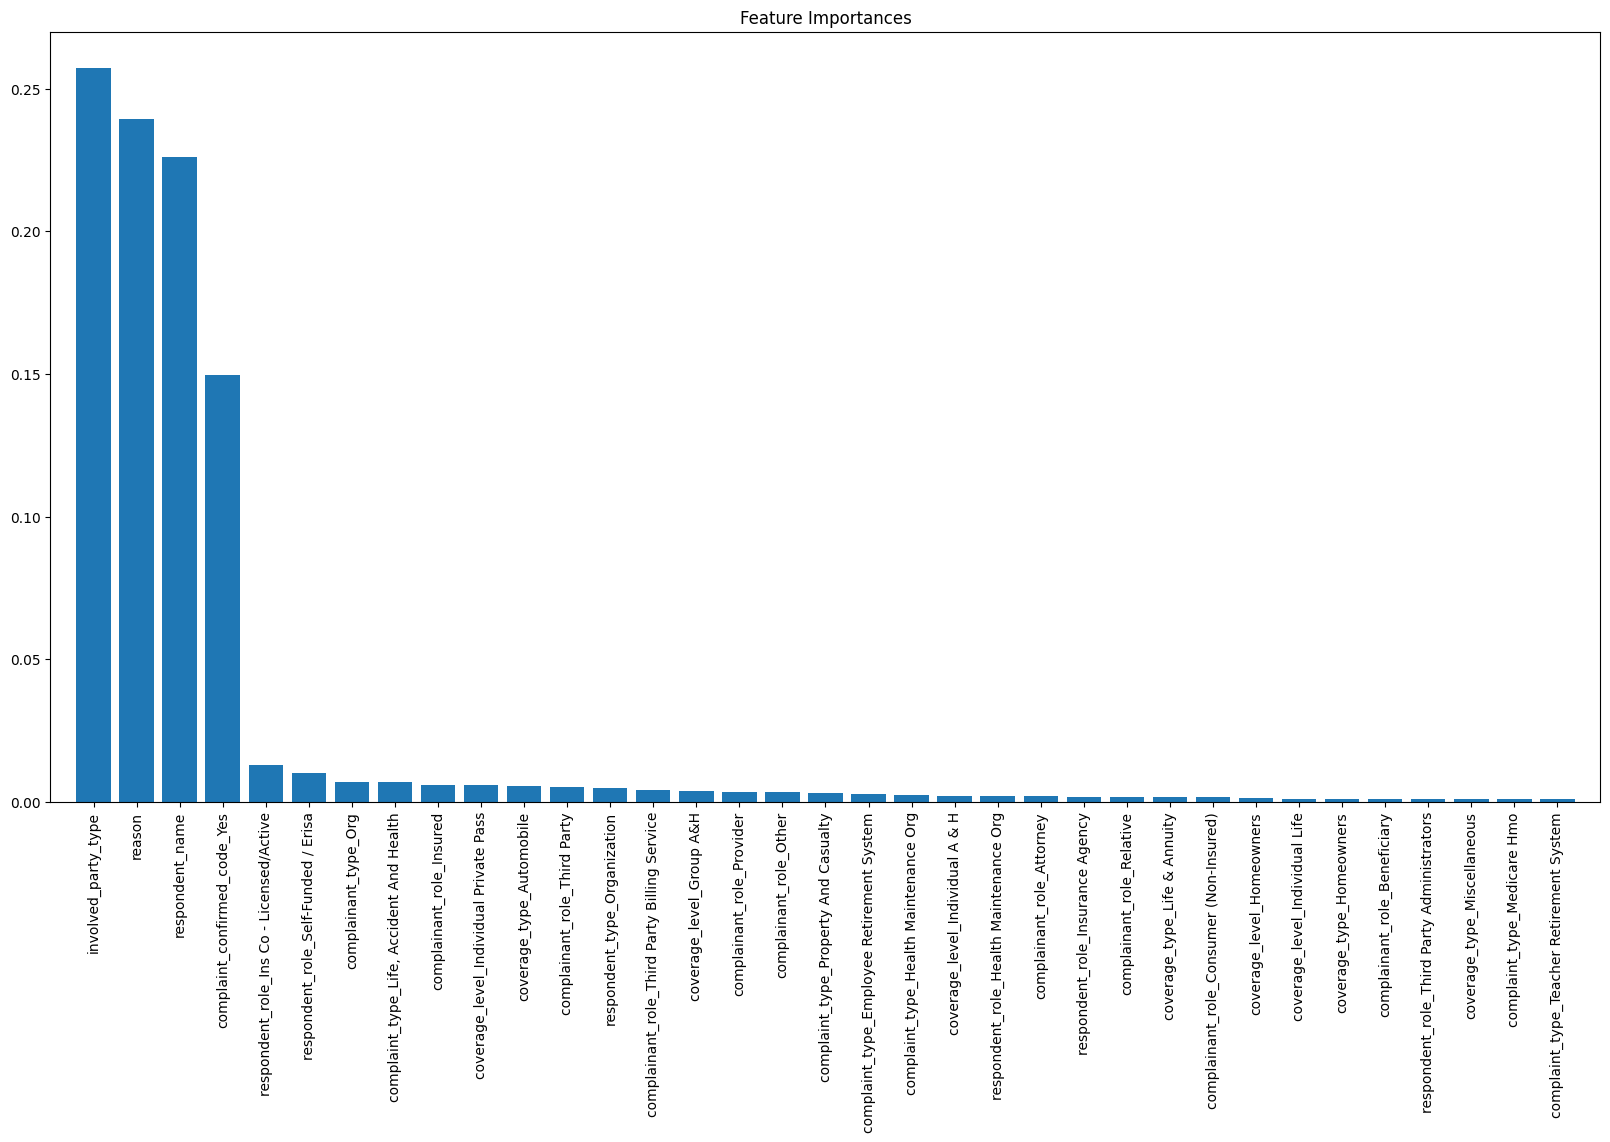

In [212]:
import matplotlib.pyplot as plt

# Get the feature importances
importances = model.feature_importances_

# Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]

# Get the indices of features whose importance is greater than 0.01
important_indices = [i for i in indices if importances[i] > 0.001]

# Filter out the non-important features
important_features = X.columns[important_indices]

# Print the feature ranking
print("Feature ranking:")
for i in important_indices:
    print(f"{X.columns[i]}: {importances[i]}")

# Plot the feature importances
plt.figure(figsize=(20, 10))
plt.title("Feature Importances")
plt.bar(range(len(important_indices)), importances[important_indices], align="center")
plt.xticks(range(len(important_indices)), X.columns[important_indices], rotation=90)
plt.xlim([-1, len(important_indices)])
plt.show()

In [213]:
# # Save the model
# import joblib
# joblib.dump(model, 'model.joblib')

# # Save the feature importances
# np.save('importances.npy', importances)

# # Save the column names
# np.save('columns.npy', X.columns)

# # Save the label encoders
# import pickle
# with open('label_encoders.pkl', 'wb') as f:
#     pickle.dump(le, f)
    
# # Save the one hot encoders
# with open('one_hot_encoders.pkl', 'wb') as f:
#     pickle.dump(ohe, f)
    
# # Save the cross-validation scores
# np.save('cross_val_scores.npy', scores)

# # Save the test accuracy
# np.save('test_accuracy.npy', test_accuracy)

# # Save the validation accuracy
# np.save('val_accuracy.npy', val_accuracy)


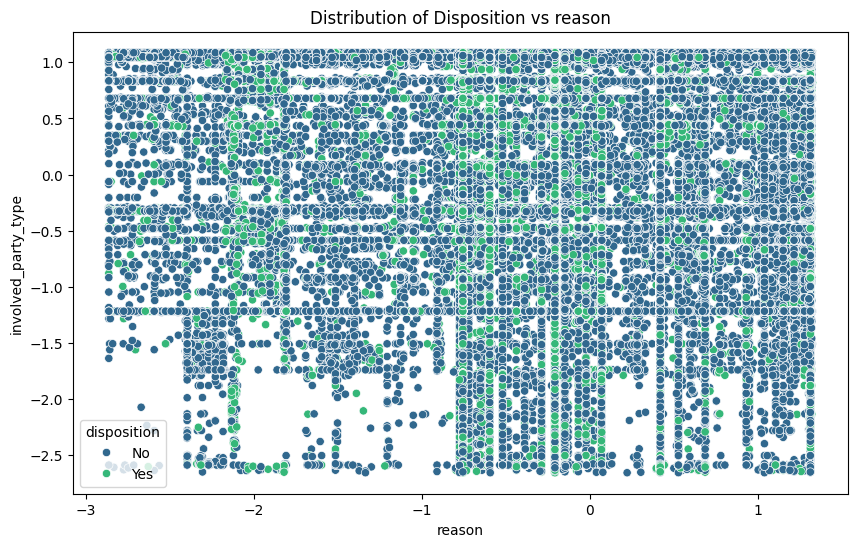

In [214]:
# Get the index of the most important feature
second_most_important_index = indices[1]

# Get the name of the most important feature
second_most_important_feature = X.columns[second_most_important_index]

# Plot the distribution of the target variable against the most important feature
plt.figure(figsize=(10, 6))
sns.scatterplot(x=second_most_important_feature, y='involved_party_type', hue='disposition', data=df, palette='viridis')
plt.title(f'Distribution of Disposition vs {second_most_important_feature}')
plt.show()

In [215]:

# keep only the impotant feature whose importance is greater than 0.01
important_indices = [i for i in indices if importances[i] > 0.01]

# filter out the non important features from df
# df = df.iloc[:, important_indices]

# # write the important features to a csv file
# df.to_csv('important_features.csv', index=False)

# # read the imporatant features from the csv file
# df = pd.read_csv('important_features.csv')

# print(df.info())



In [216]:
# Reduce the training and testing data   to 50000 samples
X_train = X_train.iloc[:100000, important_indices]
y_train = y_train.iloc[:100000]
X_test = X_test.iloc[:100000, important_indices]
y_test = y_test.iloc[:100000]

### Support Vector Machines

In [ ]:

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier

# Initialize the SVM model
svm_model = LinearSVC()

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')s
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.7837206304186676
Confusion Matrix:
[[42674  2501]
 [10920  5959]]
Classification Report:
              precision    recall  f1-score   support

          No       0.80      0.94      0.86     45175
         Yes       0.70      0.35      0.47     16879

    accuracy                           0.78     62054
   macro avg       0.75      0.65      0.67     62054
weighted avg       0.77      0.78      0.76     62054

